<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-03-27 19:08:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2021-03-27 19:08:11 (14.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

In [8]:
#TO SAVE TIME TURNING IT OFF!!!
#import seaborn as sns 

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
#g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
#g.map(plt.hist, 'Principal', bins=bins, ec="k")

#g.axes[-1].legend()
plt.show()

In [9]:
#bins = np.linspace(df.age.min(), df.age.max(), 10)
#g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
#g.map(plt.hist, 'age', bins=bins, ec="k")

#g.axes[-1].legend()
#plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
#g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
#g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
#g.axes[-1].legend()
#plt.show()


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              0              0.750000
                      1              0.250000
High School or Below  0              0.741722
                      1              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               0              0.765101
                      1              0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()


,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [16]:

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature.head()


,Principal,terms,age,Gender,weekend
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,0
3,1000,30,28,1,1
4,1000,30,29,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,0
3,1000,30,28,1,1
4,1000,30,29,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
#Always normalize your data
#Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))


In [21]:
#Do split of data in to testng data set and train the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

#Commence of Clasification
# Classification
# K nearest neighbor (KNN)
# Import library
#
# Classifier implementing the k-nearest neighbors vote.

from sklearn.neighbors import KNeighborsClassifier
# Training
#
print('Lets start the algorithm with k=4 for now:')

k = 4
#Train Model and Predict
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
print(neigh)

# Predicting
#
# we can use the model to predict the test set:
yhat = neigh.predict(X_test)
print(yhat[0:5])


# Accuracy evaluation
#
# In multilabel classification, accuracy classification score is a function that computes subset accuracy. This function is equal to the jaccard_similarity_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

#Buiding next model this time with k=6
#So we will:
#1) Build model with k=6
#2) Predict
#3) Evaluater accuarcy

k1=6
#Train Model and Predict
neigh1 = KNeighborsClassifier(n_neighbors = k1).fit(X_train,y_train)
print(neigh1)

yhat1 = neigh.predict(X_test)
print(yhat1[0:5])

#Evaluate
print("Train set Accuracy for k=6: ", metrics.accuracy_score(y_train, neigh1.predict(X_train)))
print("Test set Accuracy for k=6: ", metrics.accuracy_score(y_test, yhat1))

#kode from cursea
k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = neigh6.predict(X_test)
print("Train set Accuracy cursea k6: ", metrics.accuracy_score(y_train, neigh6.predict(X_train)))
print("Test set Accuracy: cursea k6", metrics.accuracy_score(y_test, yhat6))

Train set: (242, 5) (242,)
Test set: (104, 5) (104,)
Lets start the algorithm with k=4 for now:
KNeighborsClassifier(n_neighbors=4)
[0 0 0 0 0]
Train set Accuracy:  0.78099173553719
Test set Accuracy:  0.6826923076923077
KNeighborsClassifier(n_neighbors=6)
[0 0 0 0 0]
Train set Accuracy for k=6:  0.8057851239669421
Test set Accuracy for k=6:  0.6826923076923077
Train set Accuracy cursea k6:  0.8057851239669421
Test set Accuracy: cursea k6 0.6826923076923077


Accurqacy for K 1
0.7115384615384616
Accurqacy for K 2
0.7692307692307693
Accurqacy for K 3
0.6538461538461539
Accurqacy for K 4
0.6826923076923077
Accurqacy for K 5
0.6442307692307693
Accurqacy for K 6
0.6826923076923077
Accurqacy for K 7
0.6346153846153846
Accurqacy for K 8
0.6826923076923077
Accurqacy for K 9
0.6730769230769231
Accurqacy for K 10
0.7019230769230769
Accurqacy for K 11
0.6826923076923077
Accurqacy for K 12
0.7019230769230769
Accurqacy for K 13
0.6826923076923077
Accurqacy for K 14
0.7019230769230769
Accurqacy for K 15
0.6826923076923077
Accurqacy for K 16
0.6826923076923077
Accurqacy for K 17
0.6826923076923077
Accurqacy for K 18
0.7115384615384616


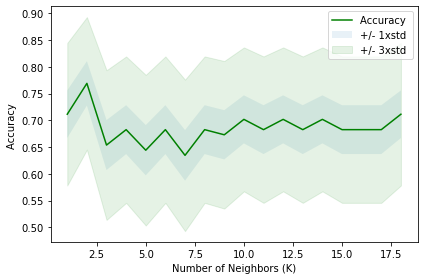

The best accuracy was with 0.7692307692307693 with k= 2


In [22]:
# What about other K?
#
# K in KNN, is the number of nearest neighbors to examine. It is supposed to be specified by the User. So, how can we choose right value for K? The general solution is to reserve a part of your data for testing the accuracy of the model. Then chose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.
#
# We can calculate the accuracy of KNN for different Ks.

Ks = 19
mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))

for n in range(1, Ks):
    # Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n - 1] = metrics.accuracy_score(y_test, yhat)
    print('Accurqacy for K' + ' ' + str(n))
    print(metrics.accuracy_score(y_test, yhat))
    std_acc[n - 1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])


# Plot model accuracy for Different number of Neighbors

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)
Best_KNN_Model = KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1).fit(X_train, y_train)

# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
# Pre-processing

#     X as the Feature Matrix (data of my_data)
#     y as the response vector (target)
#
# Lets reuse already normalzec X featureset and y labels or target value

X[0:5]
y[0:5]

array([0, 0, 0, 0, 0])

In [24]:
 #Now train_test_split will return 4 different parameters. We will name them:
# X_trainset, X_testset, y_trainset, y_testset
#
# The train_test_split will need the parameters:
# X, y, test_size=0.3, and random_state=3.
#
# The X and y are the arrays required before the split, the test_size represents the ratio of the testing dataset, and the random_state ensures that we obtain the same splits.

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

# Practice
# Print the shape of X_trainset and y_trainset. Ensure that the dimensions match

print(X_trainset.shape)

#cursea
print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y training set {}'.format(y_trainset.shape))
print('Shape of X training set {}'.format(X_testset.shape),'&',' Size of Y training set {}'.format(y_testset.shape))


# Modeling
# We will first create an instance of the DecisionTreeClassifier called loanStatusTree.
# Inside of the classifier, specify criterion="entropy" so we can see the information gain of each node.

loanStatusTree = DecisionTreeClassifier(criterion="entropy", max_depth = 80)
print(loanStatusTree) # it shows the default parameters

#Next, we will fit the data with the training feature matrix X_trainset and training response vector y_trainset
loanStatusTree.fit(X_trainset,y_trainset)

#Prediction
# Let's make some predictions on the testing dataset and store it into a variable called predTree.

predloanStatusTree = loanStatusTree.predict(X_testset)
print (predloanStatusTree [0:5])
print (y_testset [0:5])


(242, 5)
Shape of X training set (242, 5) &  Size of Y training set (242,)
Shape of X training set (104, 5) &  Size of Y training set (104,)
DecisionTreeClassifier(criterion='entropy', max_depth=80)
[0 0 1 0 0]
[0 0 1 1 0]


DecisionTrees's Accuracy:  0.7307692307692307
Index(['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')


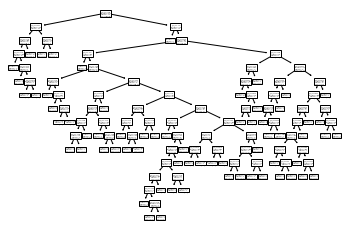

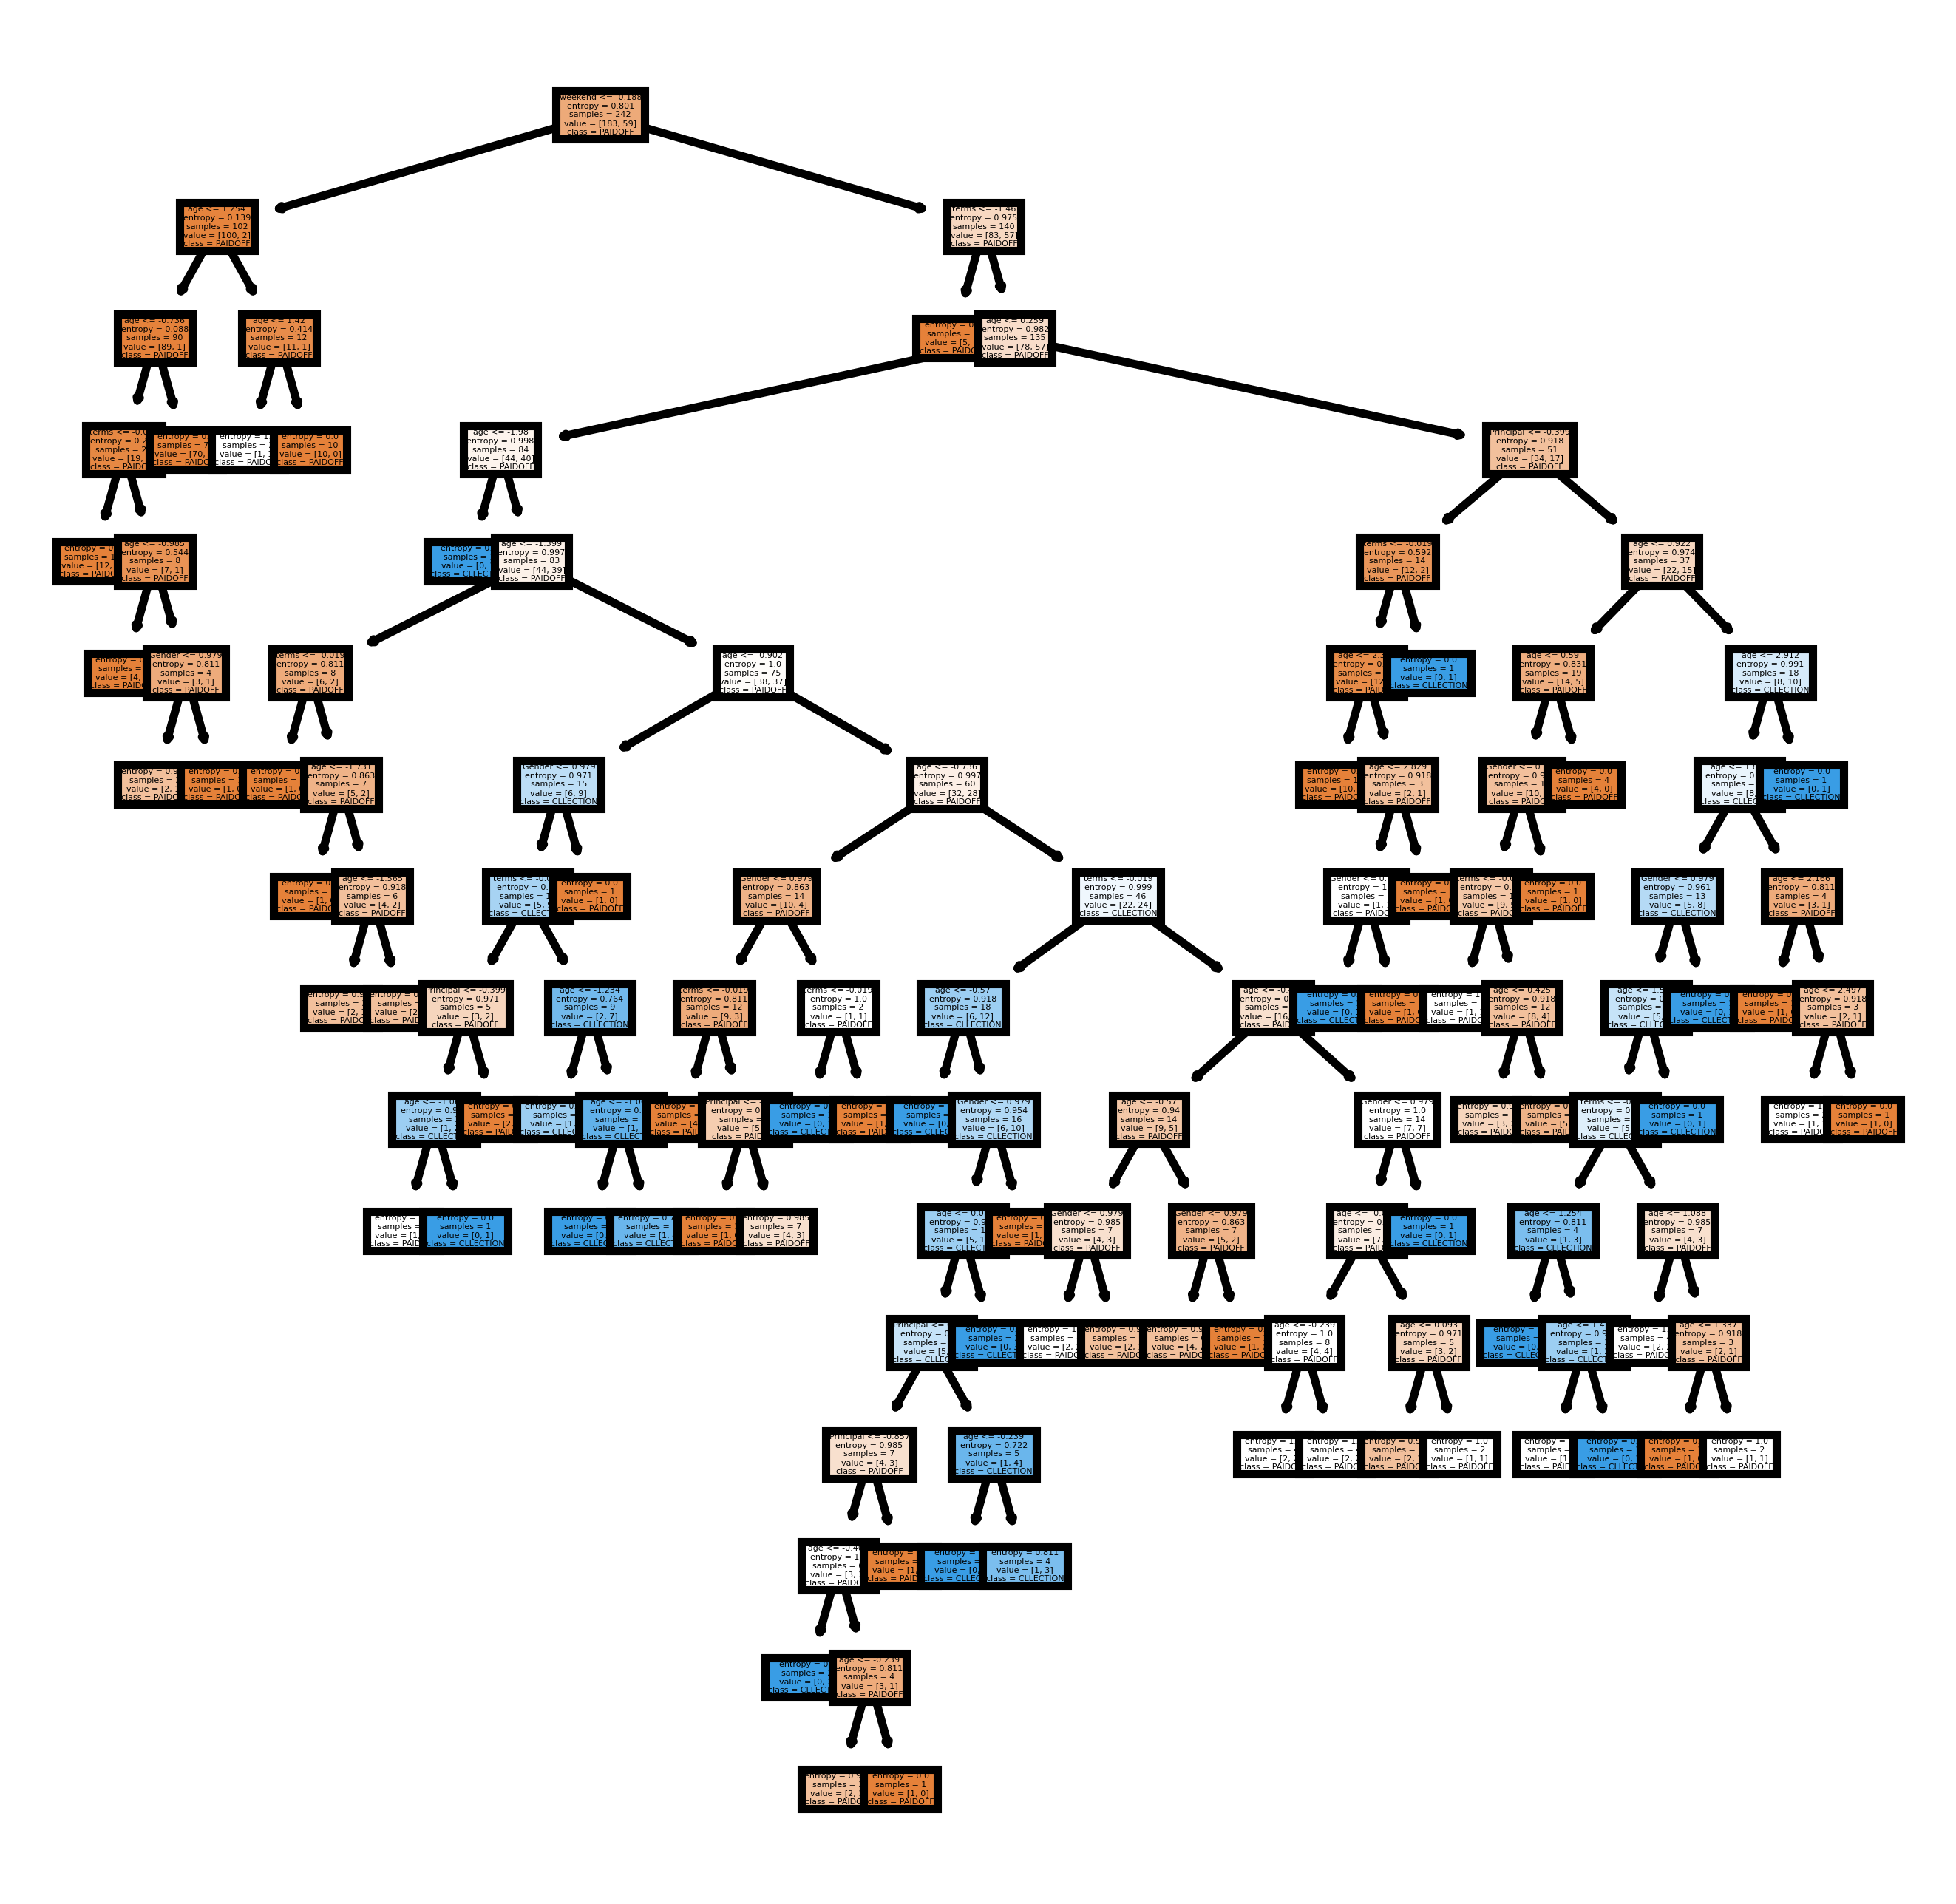

In [25]:
# Evaluation
# Next, let's import metrics from sklearn and check the accuracy of our model.
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predloanStatusTree))

tree.plot_tree(loanStatusTree)
print(Feature.columns)
fn=Feature.columns
cn=['PAIDOFF', 'CLLECTION']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(loanStatusTree,
               feature_names = fn,
               class_names=cn,
               filled = True);

fig.savefig('LoanTree.png')

# Support Vector Machine

[0 0 0 0 0 0 0 0 0 0]
[[ 0.51578458  0.92071769  2.33152555 -0.42056004 -1.20577805]
 [ 0.51578458  0.92071769  0.34170148  2.37778177 -1.20577805]
 [ 0.51578458 -0.95911111 -0.65321055 -0.42056004 -1.20577805]
 [ 0.51578458  0.92071769 -0.48739188  2.37778177  0.82934003]
 [ 0.51578458  0.92071769 -0.3215732  -0.42056004  0.82934003]
 [ 0.51578458  0.92071769  0.8391575  -0.42056004  0.82934003]
 [ 0.51578458  0.92071769 -0.48739188 -0.42056004  0.82934003]
 [-1.31458942 -0.95911111 -0.81902922 -0.42056004  0.82934003]
 [-5.89052444 -1.96168647 -0.3215732  -0.42056004  0.82934003]
 [ 0.51578458 -0.95911111  1.33661351 -0.42056004  0.82934003]]
     Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0         1000     30   45       0        0         0                     1   
1         1000     30   33       1        0         1                     0   
2         1000     15   27       0        0         0                     0   
3         1000     30   28     

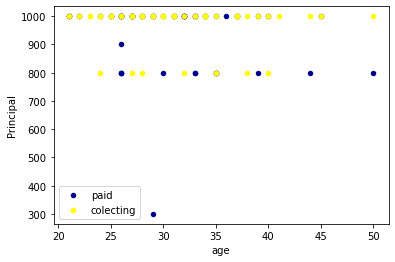

In [26]:
#Lets reuse data stet
print(y[:10])
print(X[:10])
exdendedFeature = pd.concat([Feature, df['loan_status']], axis=1)
print(exdendedFeature[exdendedFeature['loan_status'] == 0])
ax = exdendedFeature[exdendedFeature['loan_status'] == 0][0:50].plot(kind='scatter', x='age', y='Principal', color='DarkBlue', label='paid');
exdendedFeature[exdendedFeature['loan_status'] == 1][0:50].plot(kind='scatter', x='age', y='Principal', color='Yellow', label='colecting', ax=ax);

In [27]:
#X will be our independent variable matrix
#while y will be still our depend
#Train and split data set in to training
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

#see what it learns
# After being fitted, the model can then be used to predict new values:
print('check predictions... ')
yhat = clf.predict(X_test)
print(yhat [0:5])

#evaluate if it leanr correctly using confussion matrix (how many false negatives and fale positives and vic vers
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)
check predictions... 
[0 0 0 0 0]


              precision    recall  f1-score   support

           0       0.79      1.00      0.88        55
           1       0.00      0.00      0.00        15

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


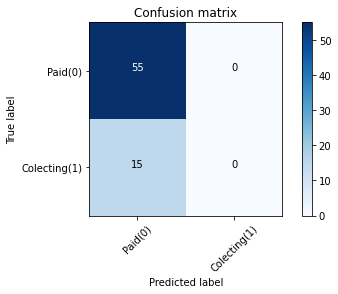

In [28]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid(0)','Colecting(1)'],normalize= False,  title='Confusion matrix')


# Logistic Regression

In [29]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [30]:
#reusind data set
loansStatus_df = pd.read_csv("loan_train.csv")
#normalize data!!!
loansStatus_df = loansStatus_df[['loan_status', 'Principal', 'terms', 'effective_date', 'due_date', 'age', 'education', 'Gender']]

loansStatus_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
loansStatus_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

loansStatus_df['due_date'] = pd.to_datetime(loansStatus_df['due_date'])
loansStatus_df['effective_date'] = pd.to_datetime(loansStatus_df['effective_date'])
loansStatus_df['dayofweek'] = loansStatus_df['effective_date'].dt.dayofweek
loansStatus_df['weekend'] = loansStatus_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

Feature = loansStatus_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

print(loansStatus_df.head())
#Show parameters and size of dataset
print(Feature.head())

print(loansStatus_df.shape)

   loan_status  Principal  terms effective_date   due_date  age  \
0            0       1000     30     2016-09-08 2016-10-07   45   
1            0       1000     30     2016-09-08 2016-10-07   33   
2            0       1000     15     2016-09-08 2016-09-22   27   
3            0       1000     30     2016-09-09 2016-10-08   28   
4            0       1000     30     2016-09-09 2016-10-08   29   

              education  Gender  dayofweek  weekend  
0  High School or Below       0          3        0  
1              Bechalor       1          3        0  
2               college       0          3        0  
3               college       1          4        1  
4               college       0          4        1  
   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0 

[0 0 0 0 0]
Before normalization
[[1000   30   45    0    0]
 [1000   30   33    1    0]
 [1000   15   27    0    0]
 [1000   30   28    1    1]
 [1000   30   29    0    1]]
[[ 0.52  0.92  2.33 -0.42 -1.21]
 [ 0.52  0.92  0.34  2.38 -1.21]
 [ 0.52 -0.96 -0.65 -0.42 -1.21]
 [ 0.52  0.92 -0.49  2.38  0.83]
 [ 0.52  0.92 -0.32 -0.42  0.83]]
Train set: (276, 5) (276,)
Test set: (70, 5) (70,)
LogisticRegression(C=0.01, solver='liblinear')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[[0.5  0.5 ]
 [0.55 0.45]
 [0.7  0.3 ]
 [0.66 0.34]
 [0.68 0.32]
 [0.69 0.31]
 [0.52 0.48]
 [0.53 0.47]
 [0.66 0.34]
 [0.5  0.5 ]
 [0.66 0.34]
 [0.5  0.5 ]
 [0.75 0.25]
 [0.66 0.34]
 [0.57 0.43]
 [0.74 0.26]
 [0.48 0.52]
 [0.69 0.31]
 [0.5  0.5 ]
 [0.68 0.32]
 [0.56 0.44]
 [0.5  0.5 ]
 [0.49 0.51]
 [0.53 0.47]
 [0.59 0.41]
 [0.5  0.5 ]
 [0.49 0.51]
 [0.63 0.37]
 [0.49 0.51]
 [0.75 0.25]
 [0.53 0.47]
 [0.54 0.46]
 [0

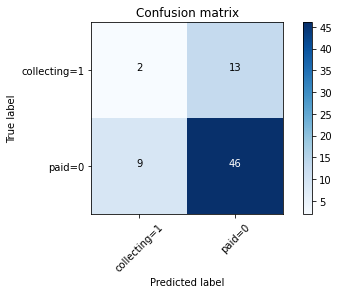

              precision    recall  f1-score   support

           0       0.78      0.84      0.81        55
           1       0.18      0.13      0.15        15

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

LogLoss: : 0.49


In [31]:
#def X and y for our dataset
#start with X independend vars:
#X = np.asarray(Feature[['Principal', 'terms', 'age', 'Gender', 'weekend', 'weekend', 'Bechalor', 'High School or Below', 'college']])
X = np.asarray(Feature[['Principal','terms','age','Gender','weekend']])
X[0:5]

#Y define dependedn var y
y = np.asarray(loansStatus_df['loan_status'])
print(y [0:5])                     

#normalze data
print("Before normalization")
print(X[0:5])
from sklearn import preprocessing
#X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X = preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])

#Train data set
#1) split our dataset into train and test set:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


#Modeling
# #Lets build our model using LogisticRegression from Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in internet.
#
# The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem in machine learning models. C parameter indicates inverse of regularization strength which must be a positive float. Smaller values specify stronger regularization. Now lets fit our model with train set:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
print(LR)

#Prediction using test set X_test
yhat = LR.predict(X_test)
print(yhat)

# predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X):
yhat_prob = LR.predict_proba(X_test)
print(yhat_prob)


# Evaluation??
# jaccard index
#
# Lets try jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by the size of the union of two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

from sklearn.metrics import jaccard_score
print(jaccard_score(y_test, yhat))

#Evaluation 2.0
# confusion matrix
#
# Another way of looking at accuracy of classifier is to look at confusion matrix.
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['collecting=1','paid=0'],normalize= False,  title='Confusion matrix')

plt.show()
print (classification_report(y_test, yhat))


from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)


LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob2))


# Model Evaluation using Test set

In [32]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [33]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-03-27 19:08:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-03-27 19:08:25 (72.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [49]:
#Load Data From CSV File
df = pd.read_csv('loan_test.csv')
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])


#Pre-processing: Feature selection/extraction
#Lets look at the day of the week people get the loan
df['dayofweek'] = df['effective_date'].dt.dayofweek
#Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.groupby(['education'])['loan_status'].value_counts(normalize=True)
#Selecting features
Feature = df[['Principal','terms','age','Gender','weekend']]
Xknn = Feature

ytest = df['loan_status'].values
print(ytest)
Xknn= preprocessing.StandardScaler().fit(Xknn).transform(Xknn)
print(Xknn[:10])
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)

Feature.drop(['Master or Above'], axis = 1,inplace=True)

Xknn = preprocessing.StandardScaler().fit(Xknn).transform(Xknn.astype(float))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 0.49  0.93  3.06  1.98 -1.3 ]
 [-3.56 -1.7   0.53 -0.51  0.77]
 [ 0.49  0.93  1.88  1.98  0.77]
 [ 0.49  0.93 -0.98 -0.51  0.77]
 [-0.67 -0.79 -0.48 -0.51  0.77]
 [-1.24 -0.79  0.2  -0.51  0.77]
 [ 0.49 -0.79 -1.32 -0.51  0.77]
 [ 0.49  0.93  0.03 -0.51  0.77]
 [-0.67 -0.79 -0.81  1.98  0.77]
 [ 0.49 -0.79  0.87 -0.51  0.77]]


In [50]:
#running models on 4 algortimts

#KNN
KNNModel = Best_KNN_Model
print(Best_KNN_Model)
#Running data trough model and captutinrg accuracy
KNNpred = KNNModel.predict(Xknn)
print(KNNpred [0:5])

#Decyssion trees
predloanStatusTree = loanStatusTree.predict(Xknn)
print (predloanStatusTree [0:5])

# Evaluation
# Next, let's import metrics from sklearn and check the accuracy of our model.
from sklearn import tree
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y, predloanStatusTree))

#SVM
SVMpred = clf.predict(Xknn)

print(SVMpred [0:5])
#LogRegression
LogRegPred = LR.predict(Xknn)


KNeighborsClassifier(n_neighbors=2)
[0 0 0 1 0]
[0 0 0 1 0]
DecisionTrees's Accuracy:  0.7037037037037037
[0 0 0 0 0]


In [61]:
#prparing evaluators Jaccard; F1 score and Logloss
#Use jaccardscore
from sklearn.metrics import jaccard_score
results = np.array(['Algorithm','Jaccard','F1-score','LogLoss'])
KnnResult = ['KNN',jaccard_score(ytest, KNNpred),f1_score(ytest, KNNpred, average='weighted'),'N/A']
DTResult = ['Decision Tree',jaccard_score(ytest, predloanStatusTree),f1_score(ytest, predloanStatusTree, average='weighted'),'N/A']
SVMResult = ['SVM',jaccard_score(ytest, SVMpred),f1_score(ytest, SVMpred, average='weighted'),'N/A']
LRResult = ['LogisticRegression',jaccard_score(ytest, LogRegPred),f1_score(ytest, LogRegPred, average='weighted'),log_loss(ytest, LogRegPred)]
results = np.vstack([results, KnnResult, DTResult, SVMResult, LRResult])






[['Algorithm' 'Jaccard' 'F1-score' 'LogLoss']
 ['KNN' '0.0625' '0.6491417079652374' 'N/A']
 ['Decision Tree' '0.058823529411764705' '0.6378600823045267' 'N/A']
 ['SVM' '0.0' '0.6304176516942475' 'N/A']
 ['LogisticRegression' '0.06666666666666667' '0.6604267310789049'
  '8.954512391225549']]


In [62]:
print(results)

[['Algorithm' 'Jaccard' 'F1-score' 'LogLoss']
 ['KNN' '0.0625' '0.6491417079652374' 'N/A']
 ['Decision Tree' '0.058823529411764705' '0.6378600823045267' 'N/A']
 ['SVM' '0.0' '0.6304176516942475' 'N/A']
 ['LogisticRegression' '0.06666666666666667' '0.6604267310789049'
  '8.954512391225549']]


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>